In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm

In [2]:
df = pd.read_csv('../data/stock.csv', index_col='date', parse_dates=True).sort_index()

In [3]:
# ボリンジャーバンド & 出来高循環分析
# https://barista-stock.hatenablog.com/entry/technical-analysis

stocks = []

for code in tqdm(df.code.unique()):
    df_picked = df.loc[df.code==code, ['closed_adj', 'volume']]
    sma_short = df_picked.apply(lambda x: x.rolling(5).mean().round(1), axis=0).add_prefix('short_')
    sma_middle = df_picked.apply(lambda x: x.rolling(25).mean().round(1), axis=0).add_prefix('middle_')
    sma_long = df_picked.apply(lambda x: x.rolling(75).mean().round(1), axis=0).add_prefix('long_')

    upper_alert = df_picked.apply(lambda x: (x.rolling(20).mean()+x.rolling(20).std(ddof=1)*2) <= x, axis=0).add_prefix('upper_alert_').astype(int)
    lower_alert = df_picked.apply(lambda x: (x.rolling(20).mean()-x.rolling(20).std(ddof=1)*2) >= x, axis=0).add_prefix('lower_alert_').astype(int)

    sma = pd.concat([df_picked, sma_short, sma_middle, sma_long, upper_alert, lower_alert], axis=1).dropna()
    sma['code'] = code
    sma['price'] = df.closed_adj[df.code==code]

    for column in ['closed_adj', 'volume']:
        stage_one = (sma[f"short_{column}"] >= sma[f"long_{column}"]) & (sma[f"short_{column}"] >= sma[f"middle_{column}"]) & (sma[f"middle_{column}"] >= sma[f"long_{column}"])
        stage_two = (sma[f"short_{column}"] >= sma[f"long_{column}"]) & (sma[f"short_{column}"] < sma[f"middle_{column}"]) & (sma[f"middle_{column}"] >= sma[f"long_{column}"])
        stage_three = (sma[f"short_{column}"] < sma[f"long_{column}"]) & (sma[f"short_{column}"] < sma[f"middle_{column}"]) & (sma[f"middle_{column}"] >= sma[f"long_{column}"])
        stage_four = (sma[f"short_{column}"] < sma[f"long_{column}"]) & (sma[f"short_{column}"] < sma[f"middle_{column}"]) & (sma[f"middle_{column}"] < sma[f"long_{column}"])
        stage_five = (sma[f"short_{column}"] < sma[f"long_{column}"]) & (sma[f"short_{column}"] >= sma[f"middle_{column}"]) & (sma[f"middle_{column}"] < sma[f"long_{column}"])
        stage_six = (sma[f"short_{column}"] >= sma[f"long_{column}"]) & (sma[f"short_{column}"] >= sma[f"middle_{column}"]) & (sma[f"middle_{column}"] < sma[f"long_{column}"])
        sma[f'{column}_stage'] = stage_one+stage_two*2+stage_three*3+stage_four*4+stage_five*5+stage_six*6
        sma['price_stage_second'] = sma.closed_adj_stage.rolling(2).mean() == sma.closed_adj_stage

    stocks.append(
        sma[[col for col in sma.columns if ('alert' in col) or ('stage' in col) or col in ('code', 'price') ]].reset_index())

df_teq = pd.concat(stocks).reset_index(drop=True).dropna()

In [5]:
df_teq.to_csv('../data/stock_teq.csv', index=None)

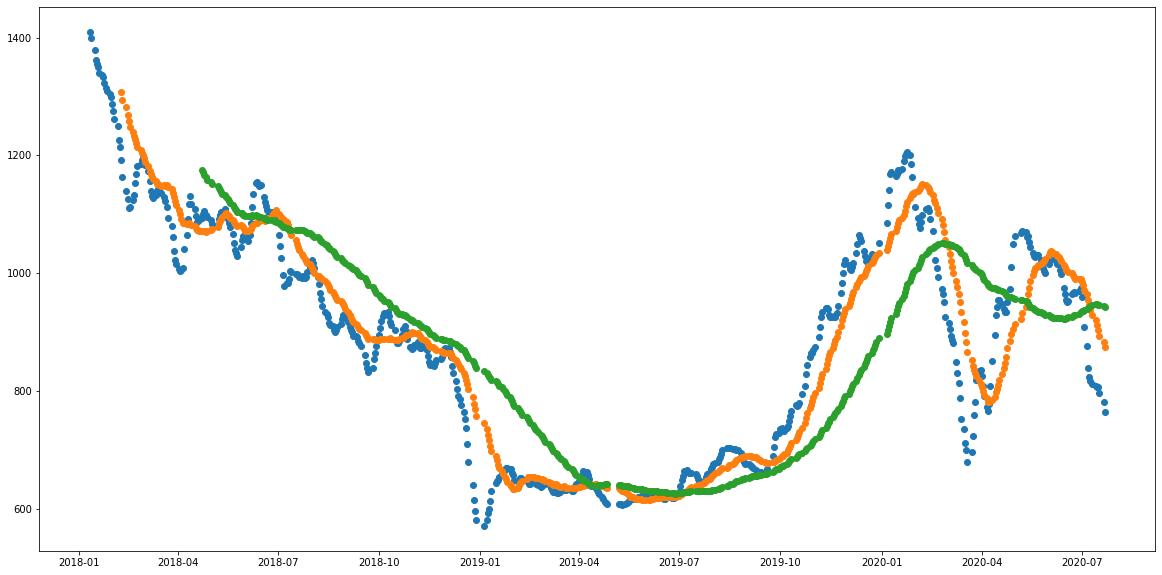

In [50]:
# https://bigdata-tools.com/moving-average/#1Simple_Moving_Average_SMA
import matplotlib.pyplot as plt

plt.figure(figsize=(20.0, 10.0))
plt.plot_date(x=price_mva_short.index, y=price_mva_short)
plt.plot_date(x=price_mva_short.index, y=price_mva_middle)
plt.plot_date(x=price_mva_short.index, y=price_mva_long)